<a href="https://colab.research.google.com/github/dhritiwasan14/Data-Science-Bowl/blob/master/U-Net/NuclearVission_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Accessing the datasets from online
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c
!wget https://www.dropbox.com/s/ec8pz3ak9ld1ftg/stage2_test_final.zip?dl=0 -c


!unzip stage1_train.zip -d  stage1_train/

!wget https://www.dropbox.com/s/ec8pz3ak9ld1ftg/stage2_test_final.zip?dl=0 -c
!unzip stage2_test_final.zip?dl=0 -d stage1_test/

In [0]:
import os
import random
import sys
import skimage
import warnings
import numpy as np
import pandas as pd
import cv2
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.segmentation import random_walker

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator 

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

seed1 = 42
random.seed = seed1
np.random.seed = seed1
smooth = 1.
epochs = 50

# # Data Path
TRAIN_PATH = 'stage1_train/'
train_ids = next(os.walk(TRAIN_PATH))[1]
#train_ids,val_ids = train_test_split(train_ids,test_size=0.2) 
print(train_ids)
TEST_PATH = 'stage1_test/'
test_ids = next(os.walk(TEST_PATH))[1]



In [0]:
import random
epochs = 100
validation_split = .10
batch_size= 2

# Function read train images and mask return as numpy array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train
  
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')
        if(len(img.shape)>2):
          img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        else:
          img=skimage.color.gray2rgb(img)
          img=img[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
          
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test
  
#https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    print("Done")
    return new_test_ids,rles

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#https://www.kaggle.com/lyakaap/weighing-boundary-pixels-loss-script-by-keras2
def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Weighted loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

#To help visualise losses during training  
class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        plt.tight_layout()
        plt.show();
      
plot_losses = PlotLosses(figsize=(16, 4))
earlystopper = EarlyStopping(patience=5, verbose=1)

# get train_data
train_img,train_mask = read_train_data()
# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


In [0]:
#https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
#U-Net with dropout
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

#U-Net without dropout  
def get_unet1(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=weighted_bce_dice_loss, metrics=[dice_coef])
    return model

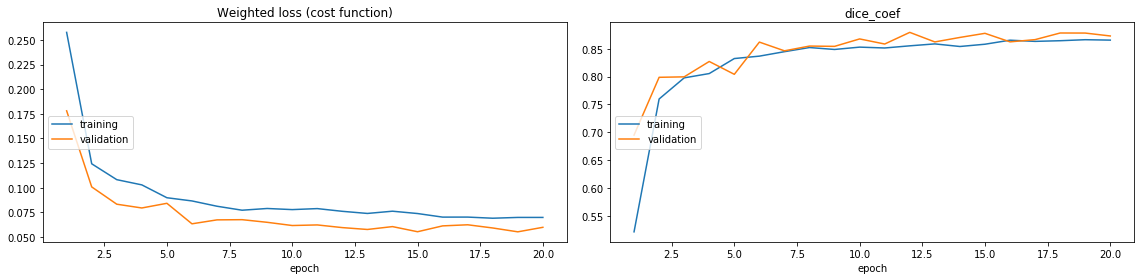

In [0]:
#Basic UNET 
model = get_unet()
results = model.fit(train_img, train_mask, validation_split=0.1, batch_size=8, epochs=20,callbacks=[plot_losses,earlystopper] 
                    )

In [0]:
#data augmentation

import imgaug as ia
from imgaug import augmenters as iaa
vert_flipper = iaa.Fliplr(1.0)
horizontal_flipper = iaa.Flipud(1.0)
X_train_aug = np.zeros((len(train_ids) * 4, 256, 256, 3), dtype=np.uint8)
Y_train_aug = np.zeros((len(train_ids) * 4, 256, 256, 1), dtype=np.bool)

for i in range(0, len(train_img)):
    X_train_aug[i * 4] = train_img[i]
    Y_train_aug[i * 4] = train_mask[i]
    X_train_aug[i * 4 + 1] = vert_flipper.augment_image(train_img[i])
    Y_train_aug[i * 4 + 1] = vert_flipper.augment_image(train_mask[i])
    X_train_aug[i * 4 + 2] = horizontal_flipper.augment_image(train_img[i])
    Y_train_aug[i * 4 + 2] = horizontal_flipper.augment_image(train_mask[i])
    X_train_aug[i * 4 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(train_img[i]))
    Y_train_aug[i * 4 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(train_mask[i]))
    

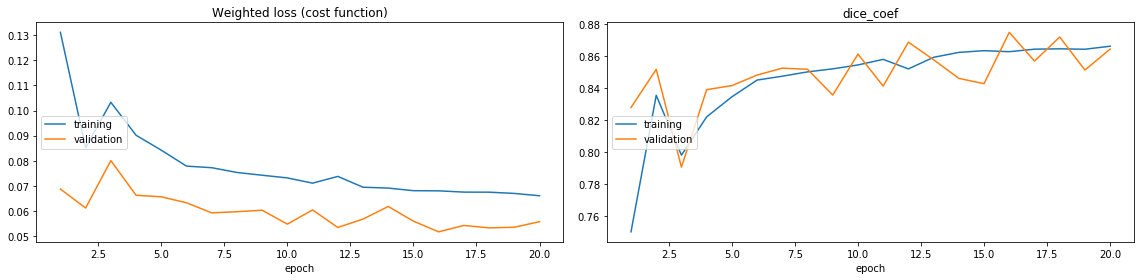

In [0]:
#Basic U-Net + data augmentation
model_improved = get_unet()
results2 = model_improved.fit(X_train_aug, Y_train_aug, shuffle=True, validation_split=0.1, batch_size=3, epochs=20, 
                    callbacks=[plot_losses,earlystopper])

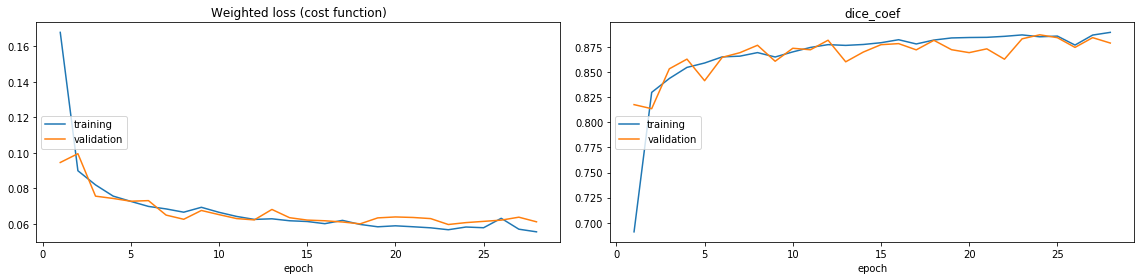

Epoch 00028: early stopping


In [0]:
#Using weighted loss at boundary pixels
model_improved1 = get_unet()
results3 = model_improved1.fit(X_train_aug, Y_train_aug, shuffle=True, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[plot_losses, earlystopper])


In [0]:
print("Predicting")
# Predict on test data
test_mask = model_improved1.predict(test_img,verbose=1)

# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_mask)):
    test_mask_upsampled.append(resize(np.squeeze(test_mask[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))


Predicting
3019/3019 [==============================] - 12s 4ms/step


In [0]:
   
final_mask=[]
#https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html
for i in test_mask_upsampled:
  rand_mask=i
  cv2.imwrite('rand.jpg', rand_mask)
  c = cv2.imread('rand.jpg', 1)
  gray = cv2.cvtColor(c,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
  sure_bg = cv2.dilate(opening,kernel,iterations=3)
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  output = cv2.connectedComponentsWithStats(sure_fg)
  markers = output[1]
  stats = output[2]
  markers = markers+1
  markers[unknown==255] = 0
  markers=cv2.watershed(c,markers)
  rand_mask[markers==-1] = 0
  rand_mask[markers==1] = 0
  markers = markers -1
  rand_mask[markers==-1] = 0
  final_mask.append(rand_mask)
  
  
test_ids,rles = mask_to_rle(test_mask_upsampled)

Done


In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('dsb.csv', index=False)
# Code to download files from Google colab
from google.colab import files

files.download('dsb.csv')